Minimal example for masking tests.

In [1]:
import numpy as np
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import estimator as est
rng = np.random.default_rng(seed=315)
from forestflow.model_p3d_arinyo import ArinyoModel
from forestflow.archive import GadgetArchive3D
from lace.cosmo import camb_cosmo
from forestflow import pcross
from scipy.interpolate import interp1d
import mask_calculations as mc


In [2]:
# set simulation details
sim_name='sim_pair_30' # other version will be 'diffSeed'
sim_dir='central'
snap_num = 6
phase = "sim_minus"
axis = 1
# load the saved skewer deltas
meas_path = "/Users/mlokken/research/lyman_alpha/data/"
delta_x = np.load(meas_path+"snap_{:d}/delta_x/skewers_6_psim_minus_ax1_Ns768_wM0.05_sT1.0_sg1.0.npz".format(snap_num))
delta_flux_x = delta_x['delta_flux_x']
Np = delta_flux_x.shape[1]
L = delta_x['L_Mpc']
pix_spacing = L/Np
print("pixel spacing is", pix_spacing, "Mpc")
# xpar = delta_x['xpar'] # this is wrong in the saved files, redefine below
delta_x.close()
xpar = np.arange(0, L, pix_spacing)+pix_spacing/2.


pixel spacing is 0.05 Mpc


In [3]:
nskew = delta_flux_x.shape[0]
nside = np.sqrt(nskew).astype(int)
print(f"Box is {L} Mpc per side with {nside} skewers per side")
print(f"Spacing between pixels along line-of-sight = {pix_spacing} Mpc")

# bin delta_flux along line-of-sight
binsize = 5
if Np%binsize != 0:
    print("Np is not divisible by binsize")
    sys.exit()
delta_flux, xpar = est.bin_spectra(delta_flux_x, xpar, binsize)
Np=delta_flux.shape[1]
pix_spacing_b = xpar[1]-xpar[0]
print(f"Spacing between pixels along line-of-sight after binning = {pix_spacing} Mpc")
delta_flux_k = np.fft.rfft(delta_flux)
Nk = delta_flux_k.shape[1]
# get the positions
xpos = np.linspace(0,L,nside)
ypos = np.linspace(0,L,nside)
print("spacing between neighboring skewers is {:.2f} Mpc".format(xpos[1]-xpos[0]))
positions = np.array([[x,y] for x in xpos for y in ypos])

# reshape into a grid
delta_flux_grid = np.reshape(delta_flux, (int(nside), int(nside), Np))
delta_flux_k_grid = np.reshape(delta_flux_k, (int(nside), int(nside), Nk))
position_grid = np.reshape(positions, (int(nside), int(nside), 2))

subsample = True
if subsample:
    subfac = 20
    delta_flux_grid = delta_flux_grid[::subfac,::subfac,:]
    delta_flux_k_grid = delta_flux_k_grid[::subfac,::subfac,:]
    position_grid = position_grid[::subfac,::subfac,:]
    nskew = delta_flux_grid.shape[0]*delta_flux_grid.shape[1]
    nside = delta_flux_grid.shape[0]

Box is 67.5 Mpc per side with 768 skewers per side
Spacing between pixels along line-of-sight = 0.05 Mpc
Number of bins: 270


Spacing between pixels along line-of-sight after binning = 0.05 Mpc
spacing between neighboring skewers is 0.09 Mpc


Text(0.5, 1.0, '1521 skewers')

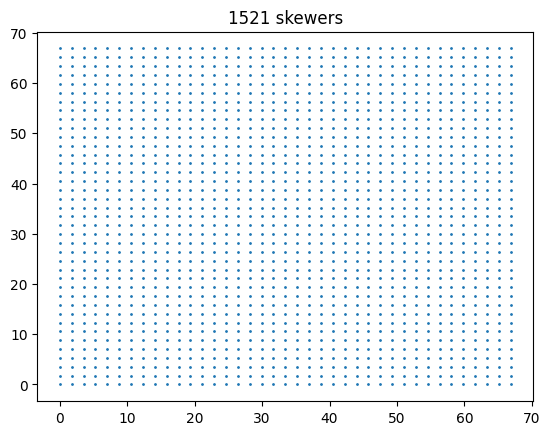

In [4]:
plt.scatter(position_grid[:,:,0], position_grid[:,:,1], s=1)
plt.title(f"{nskew} skewers")

Doing single-skyline masking


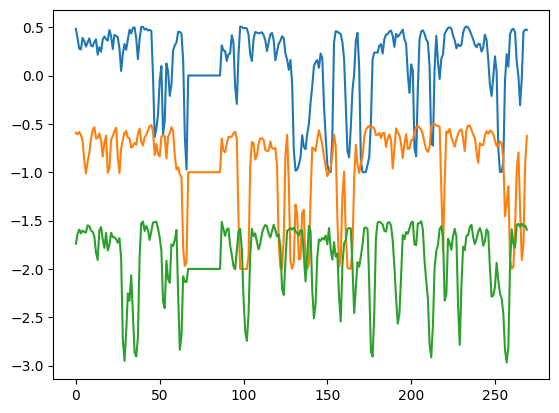

In [5]:
# simple masking: mask a range of N pixels 1/x of the way through the box
print("Doing single-skyline masking") # (with a large width to make the mask effects clear)
skyline_width = 20
boxdiv = 4
sky_maskrange = np.arange(Np//boxdiv, Np//boxdiv+skyline_width)
delta_flux_skyline_grid = np.copy(delta_flux_grid)
delta_flux_skyline_grid[:, :, sky_maskrange] = 0
nmasked_skyline = skyline_width*nskew
skyline_mask = np.ones((nside, nside, Np)) # store the mask
skyline_mask[:, :, sky_maskrange] = 0


# plot the first 3 with an offset
plt.plot(delta_flux_skyline_grid[0,0,:])
plt.plot(delta_flux_skyline_grid[1,0,:]-1)
plt.plot(delta_flux_skyline_grid[2,0,:]-2)

# get the skyline delta k
delta_flux_skyline_k_grid = np.fft.rfft(delta_flux_skyline_grid, axis=2)

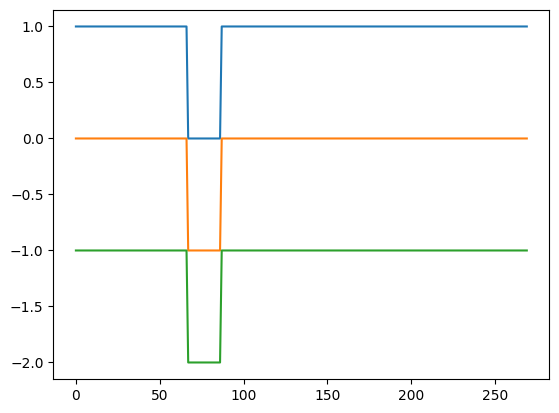

Text(0.5, 0, '$k$ [Mpc$^{-1}$]')

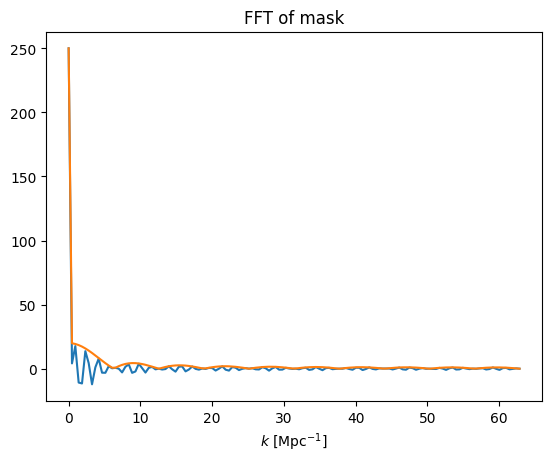

In [6]:
# plot the first 3 masks with an offset
plt.plot(skyline_mask[0,0,:])
plt.plot(skyline_mask[1,0,:]-1)
plt.plot(skyline_mask[2,0,:]-2)
plt.show()
plt.clf()

# get the rfft of the first mask (they are all the same)
kpar = np.fft.rfftfreq(Np, pix_spacing)*2*np.pi # frequency in Mpc^-1
skyline_mask_k = np.fft.rfft(skyline_mask.reshape(nskew, Np), axis=1)
plt.plot(kpar, skyline_mask_k[0,:].real, label='real part')
plt.plot(kpar, np.abs(skyline_mask_k[0,:]), label='abs value')
plt.title("FFT of mask")
plt.xlabel(r"$k$ [Mpc$^{-1}$]")

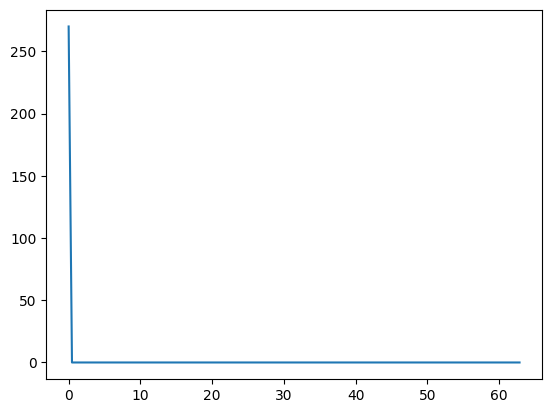

In [8]:
nonmask = np.ones((nskew, Np))
nonmask_fft = np.fft.rfft(nonmask, axis=1)
plt.plot(kpar, nonmask_fft[0,:].real, label='real part')

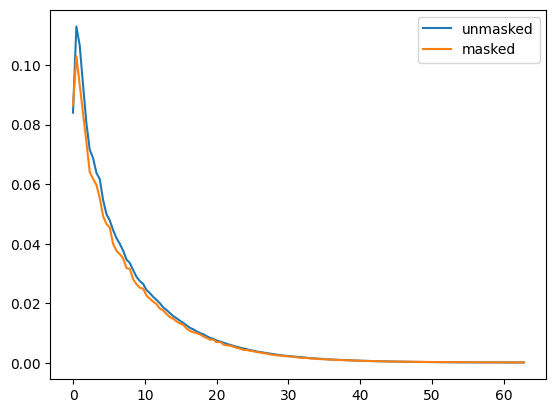

In [9]:
# get the unmasked P1D
p1d_unmasked = np.mean((delta_flux_k.__abs__())**2, axis=0)
# get the masked P1D
p1d_masked = np.mean(np.reshape(delta_flux_skyline_k_grid, (nskew, Nk)).__abs__()**2, axis=0)
# plot them together
plt.plot(kpar, p1d_unmasked*pix_spacing/Np, label="unmasked")
plt.plot(kpar, p1d_masked*pix_spacing/Np, label="masked")
plt.legend()

In [20]:
p1d_mask_model = []
for m in range(len(kpar)): # for each Fourier mode
    print(m)
    p1d_mask_model.append(mc.calculate_masked_power_rfft(m, skyline_mask_k, p1d_unmasked))

0
<class 'numpy.float64'>
1
<class 'numpy.float64'>
2
<class 'numpy.float64'>
3
<class 'numpy.float64'>
4
<class 'numpy.float64'>
5
<class 'numpy.float64'>
6
<class 'numpy.float64'>
7
<class 'numpy.float64'>
8
<class 'numpy.float64'>
9
<class 'numpy.float64'>
10
<class 'numpy.float64'>
11
<class 'numpy.float64'>
12
<class 'numpy.float64'>
13
<class 'numpy.float64'>
14
<class 'numpy.float64'>
15
<class 'numpy.float64'>
16
<class 'numpy.float64'>
17
<class 'numpy.float64'>
18
<class 'numpy.float64'>
19
<class 'numpy.float64'>
20
<class 'numpy.float64'>
21
<class 'numpy.float64'>
22
<class 'numpy.float64'>
23
<class 'numpy.float64'>
24
<class 'numpy.float64'>
25
<class 'numpy.float64'>
26
<class 'numpy.float64'>
27
<class 'numpy.float64'>
28
<class 'numpy.float64'>
29
<class 'numpy.float64'>
30
<class 'numpy.float64'>
31
<class 'numpy.float64'>
32
<class 'numpy.float64'>
33
<class 'numpy.float64'>
34
<class 'numpy.float64'>
35
<class 'numpy.float64'>
36
<class 'numpy.float64'>
37
<class '

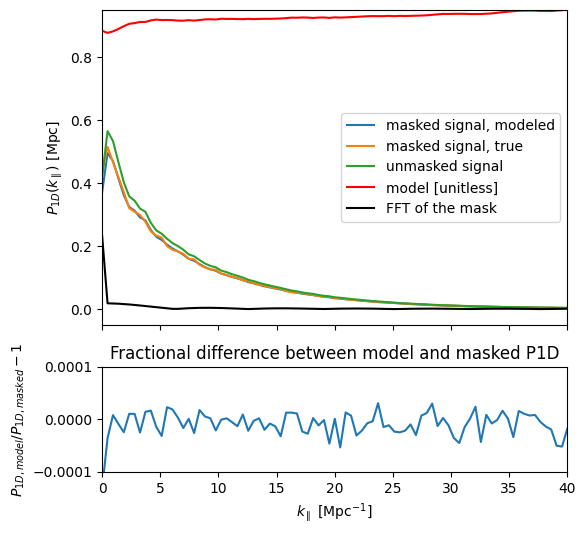

In [23]:
# plot each 
# plt.plot(kpar, np.asarray(p1d_mask_model), label='model')

cutoff = Np//2
kpar_cut = kpar[:cutoff]
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[6,6], gridspec_kw={'height_ratios': [3, 1]})
ax[0].plot(kpar_cut, np.asarray(p1d_mask_model[:cutoff])*L/Np**2, label='masked signal, modeled')
ax[0].plot(kpar_cut, p1d_masked[:cutoff]*L/Np**2, label='masked signal, true')
ax[0].plot(kpar_cut, p1d_unmasked[:cutoff]*L/Np**2, label='unmasked signal')
ax[0].plot(kpar_cut, p1d_mask_model[:cutoff]/p1d_unmasked[:cutoff], label='model [unitless]', color='r')
ax[0].plot(kpar_cut, np.abs(skyline_mask_k[0,:cutoff])*L/Np**2, label='FFT of the mask', color='k')
ax[0].legend()
ax[0].set_ylim([-.05, 0.95])
ax[0].set_ylabel(r"$P_{1D}(k_{\parallel})$ [Mpc]")
ax[1].plot(kpar_cut, ((p1d_mask_model[:cutoff]-p1d_masked[:cutoff]))/p1d_masked[:cutoff]*L/Np**2)
ax[1].set_xlim([0,40])
ax[1].set_ylabel(r"$P_{1D,model}/P_{1D,masked}-1$")
ax[1].set_title("Fractional difference between model and masked P1D")
ax[1].set_ylim([-1e-4, 1e-4])

ax[1].set_xlabel(r"$k_{\parallel}$ [Mpc$^{-1}$]")
plt.savefig("masking_model_{:.1f}pct_sameloc.pdf".format(skyline_width/Np*100))
